In [ ]:
import numpy as np
import pyedflib
from matplotlib import pyplot as plt
from pyedflib import EdfReader

from config.constants import SAMPLING_FREQUENCY_HZ
from config.paths import PATHS
import config.intervals as intervals
import pandas as pd

from utils.edf_utils import time_to_index
from config.paths import PatientDir

# Idealized case
In the ideal case, there would be a single file that contains the whole preictal interval.
In reality, the interval is not always fully contained, it can be split between files, and these files might have a break in between them.
→ It's necessary to see which portions of the preictal interval are contained or only use seizures where the entire interval is contained.


In [5]:
# load seizure annotation
patient_dir = PatientDir(PATHS.for_mayo_dir / 'B52K3P3G')
seizure_annotation_file = patient_dir.szr_anns_dir / 'B52K3P3G_CONSENSUS_corrected.csv'
seizure_annotations = pd.read_csv(seizure_annotation_file, parse_dates=['start', 'end', 'single_marker'])
seizure_annotations

,type,start,single_marker,end,comment
0,Seizure-rhythmic,NaT,2021-10-21 01:36:02.330,NaT,NaN
1,Seizure-rhythmic,NaT,2021-10-21 04:51:52.068,NaT,NaN
2,Seizure-rhythmic,NaT,2021-10-22 05:29:08.996,NaT,NaN
3,Seizure-rhythmic,NaT,2021-10-22 08:11:29.876,NaT,NaN
4,Seizure-rhythmic,NaT,2021-10-24 17:17:20.465,NaT,NaN
5,Seizure-rhythmic,NaT,2021-10-26 21:35:39.686,NaT,NaN
6,Seizure-rhythmic,NaT,2021-10-27 06:38:45.994,NaT,NaN
7,Seizure-rhythmic,NaT,2021-11-02 13:25:35.757,NaT,NaN
8,Seizure-rhythmic,NaT,2021-11-05 04:37:56.289,NaT,NaN
9,Seizure-rhythmic,NaT,2021-11-05 13:55:10.046,NaT,NaN


In [6]:
# szr_nr = 1  # A seizure where the preictal interval is fully contained in a file
szr_nr = 3  # A seizure where the preictal interval spans 2 files
seizure = seizure_annotations.loc[szr_nr]
szr_time = seizure['single_marker']
szr_time

Timestamp('2021-10-22 08:11:29.876000')

In [ ]:
preictal_end = szr_time - intervals.HORIZON
preictal_end

In [ ]:
preictal_start = szr_time - intervals.PREICTAL_INTERVAL
preictal_start

In [ ]:
# load the edf files list
edf_files_path = patient_dir.edf_files_sheet.with_suffix('.pkl')
edf_files = pd.read_csv(edf_files_path)
# edf_files

In [10]:
# find the edf file(s) that contain(s) the interval
# Find files that have any overlap with the preictal interval
# the formula a_start <= b_end and b_start <= a_end determines overlap between any intervals a and b
overlapping_interval_mask = (preictal_start <= edf_files['end']) & (edf_files['start'] <= preictal_end)
matching_edfs = edf_files[overlapping_interval_mask]
matching_edfs

,old_file_name,file_name,start,end,duration_hours,visit
73,B52K3P3G_01_0004245_20211022_33_EEGdata.edf,B52K3P3G_2021-10-22_04-10-53.edf,2021-10-22 04:10:53,2021-10-22 08:56:12.431700,4:45:19.431700,5a


In [11]:
# Find the file that contains the seizure (probably not needed in practice)
_szr_file = edf_files[(edf_files['start'] <= szr_time) & (szr_time <= edf_files['end'])]

In [12]:
# load the edf file
preictal_edf_info = matching_edfs.iloc[0]
preictal_edf_path = patient_dir.edf_dir / preictal_edf_info['file_name']
preictal_edf = EdfReader(str(preictal_edf_path))

In [ ]:
# convert the preictal end to index and select the correct slice based on that
preictal_end_idx = round(time_to_index(preictal_edf.getStartdatetime(), preictal_end, SAMPLING_FREQUENCY_HZ))
preictal_end_idx

In [ ]:
preictal_start_idx = preictal_end_idx - intervals.PREICTAL.n_samples
preictal_start_idx

In [ ]:
# load preictal interval
N_CHANNELS = preictal_edf.signals_in_file
preictal_signals = np.zeros((N_CHANNELS, intervals.PREICTAL.n_samples))
for channel in range(N_CHANNELS):
    preictal_signals[channel, :] = preictal_edf.readSignal(
        chn=channel,
        start=preictal_start_idx,
        n=intervals.PREICTAL.n_samples)
preictal_signals.shape

In [ ]:
preictal_edf.close()

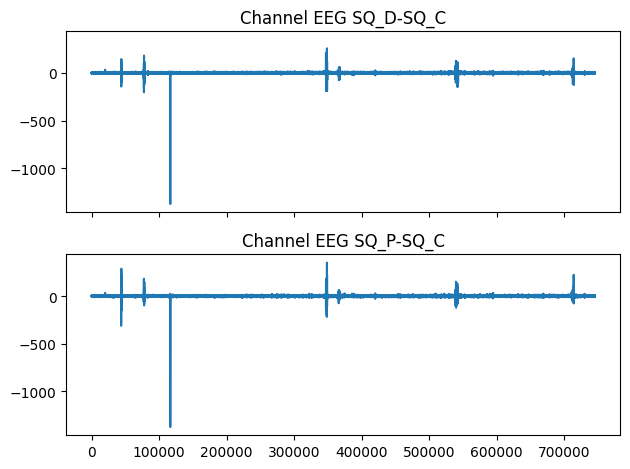

In [17]:
# plot the preictal_signals
preictal_header = pyedflib.highlevel.read_edf_header(str(preictal_edf_path))
fig, ax = plt.subplots(nrows=N_CHANNELS, sharex=True, sharey=True,
                       # figsize=(10, 10)
                       )
for channel in range(N_CHANNELS):
    ax[channel].plot(preictal_signals[channel, :])
    channel_name = preictal_header['SignalHeaders'][channel]['label']
    ax[channel].set_title(f'Channel {channel_name}')
plt.tight_layout()

In [ ]:
clips = preictal_signals.reshape((-1, N_CHANNELS, intervals.CLIP.n_samples))
clips.shape

In [ ]:
intervals.CLIP.n_samples

In [ ]:
segments = clips.reshape((clips.shape[0], -1, N_CHANNELS, intervals.SEGMENT.n_samples))
segments.shape

# Split Files case

In [21]:
matching_edfs

,old_file_name,file_name,start,end,duration_hours,visit
73,B52K3P3G_01_0004245_20211022_33_EEGdata.edf,B52K3P3G_2021-10-22_04-10-53.edf,2021-10-22 04:10:53,2021-10-22 08:56:12.431700,4:45:19.431700,5a


In [ ]:
# NOTE: we only use segments that were fully recorded in the edf file
# NOTE: this could be sped up a lot if the matching edfs were just accessed and the data was directly reshaped into the segments

# This will store whether a segment is contained the data or not
# segment_starts = {preictal_start + i * intervals.SEGMENT.exact_dur : None for i in range(segments_per_preictal_interval)}
segments = np.zeros((intervals.SEGMENTS_PER_PREICTAL_INTERVAL, N_CHANNELS, intervals.SEGMENT.n_samples))
segment_ranges = []

for i in range(intervals.SEGMENTS_PER_PREICTAL_INTERVAL):
    start = preictal_start + i * intervals.SEGMENT.exact_dur
    end = start + intervals.SEGMENT.exact_dur
    segment_ranges.append((start, end))

    # Find the edf that fully contains the segment (if any)
    segment_edf = matching_edfs[(matching_edfs['start'] <= start) & (end <= matching_edfs['end'])]

    # load the data if it exists
    if len(segment_edf) > 0:
        edf_path = patient_dir.edf_dir / segment_edf['file_name'].item()
        edf = EdfReader(str(edf_path))

        # not sure if this is correct -> the next segment could share the end of this one because of rounding
        start_idx = round(time_to_index(edf.getStartdatetime(), start, SAMPLING_FREQUENCY_HZ))

        for channel in range(N_CHANNELS):
            segments[i, channel, :] = edf.readSignal(chn=channel, start=start_idx, n=intervals.SEGMENT.n_samples)

        edf.close()

# for idx, edf in matching_edfs.iterrows():
# edf_path = patient_dir.edf_dir / edf['file_name']
# signals, signal_headers, header = highlevel.read_edf(str(edf_path))



In [ ]:
start_idx

In [24]:
print(f'{segments.shape=}')
segment_num = 144

segments.shape=(240, 2, 3105)


segment_num=144
start: 2021-10-22 07:47:30.092000
end  : 2021-10-22 07:47:45.089750


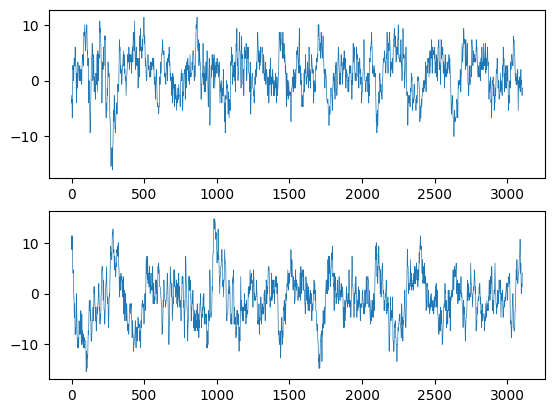

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
print(f'{segment_num=}')
print(f'start: {segment_ranges[segment_num][0]}')
print(f'end  : {segment_ranges[segment_num][1]}')
ax1.plot(segments[segment_num, 0, :], linewidth=0.5)
ax2.plot(segments[segment_num, 1, :], linewidth=0.5)
segment_num += 1

In [26]:
# Table of Segments
index = pd.MultiIndex.from_product([range(Durations.CLIPS_PER_PREICTAL_INTERVAL), range(Durations.SEGMENTS_PER_CLIP)],
                                   names=['clip', 'segment'])
segments = pd.DataFrame(index=index, columns=['start', 'end', 'exists', 'file', 'start_index'])

segments['start'] = preictal_start + segments.index.get_level_values(
    0) * Durations.CLIP + segments.index.get_level_values(1) * Durations.SEGMENT
segments['end'] = segments['start'] + Durations.SEGMENT

segments['exists'] = False
for edf in matching_edfs.iterrows():
    print(edf)
    # Set the property "exists" to True for all segments contained in the edf
    segments_contained_in_edf = edf['start'] <= segments['start'] & segments['end'] <= edf['end']
    segments[segments_contained_in_edf]['exists'] = True
    segments[segments_contained_in_edf]['file'] = edf['file_name']

# matching_edfs['start'] <= segments['start']
# matching_check = matching_edfs[(matching_edfs['start'] <= segments['start']) & (segments['end'] <= matching_edfs['end'])]
# segments['exists'] = len(matching_check) > 0


# for clip_idx in range(Durations.CLIPS_PER_PREICTAL_INTERVAL):
#     for segment_idx in range(Durations.SEGMENTS_PER_CLIP):
#         start = preictal_start + clip_idx * Durations.CLIP + segment_idx * Durations.SEGMENT
#         end = start + Durations.SEGMENT
#
#         # Find the edf that fully contains the segment (if any)
#         segment_edfs = matching_edfs[(matching_edfs['start'] <= start) & (end <= matching_edfs['end'])]
#         assert len(segment_edfs) <= 1, f"Multiple matches for segment: {start} - {end}"
#         edf_exists = len(segment_edfs) == 1
#
#         file_name = None
#         start_idx = None
#         if edf_exists:
#             segment_edf = segment_edfs.item()
#
#             file_name = segment_edf['file_name'].item()
#             edf_path = Paths.edf_dir(patient_dir) / file_name
#             edf = EdfReader(str(edf_path))
#             start_idx = time_to_index(edf.getStartdatetime(), start, Constants.SAMPLING_FREQUENCY_HZ)
#
#         segments.loc[clip_idx, segment_idx] = [start, end, edf_exists, file_name, start_idx]
#
#
#


# # This will store whether a segment is contained the data or not
# # segment_starts = {preictal_start + i * Durations.SEGMENT : None for i in range(segments_per_preictal_interval)}
# segments = np.zeros((Durations.SEGMENTS_PER_PREICTAL_INTERVAL, N_CHANNELS, Durations.SEGMENT_N_SAMPLES))
# segment_ranges = []
# #
# for i in range(Durations.SEGMENTS_PER_PREICTAL_INTERVAL):
#     start = preictal_start + i * Durations.SEGMENT
#     end = start + Durations.SEGMENT
#     segment_ranges.append((start, end))
#
#     # Find the edf that fully contains the segment (if any)
#     segment_edf = matching_edfs[(matching_edfs['start'] <= start) & (end <= matching_edfs['end'])]
#
#     # load the data if it exists
#     if len(segment_edf) > 0:
#         edf_path = Paths.edf_dir(patient_dir) / segment_edf['file_name'].item()
#         edf = EdfReader(str(edf_path))
#
#         start_idx = time_to_index(edf.getStartdatetime(), start, Constants.SAMPLING_FREQUENCY_HZ)
#
#         for channel in range(N_CHANNELS):
#             segments[i, channel, :] = edf.readSignal(chn=channel, start=start_idx, n=Durations.SEGMENT_N_SAMPLES)
#
#         edf.close()

# for idx, edf in matching_edfs.iterrows():
# edf_path = Paths.edf_dir(patient_dir) / edf['file_name']
# signals, signal_headers, header = highlevel.read_edf(str(edf_path))



(73, old_file_name     B52K3P3G_01_0004245_20211022_33_EEGdata.edf
file_name                    B52K3P3G_2021-10-22_04-10-53.edf
start                                     2021-10-22 04:10:53
end                                2021-10-22 08:56:12.431700
duration_hours                                 4:45:19.431700
visit                                                      5a
Name: 73, dtype: object)


TypeError: tuple indices must be integers or slices, not str

In [123]:
segments

start                        end exists  \
clip segment                                                                
0    0       2021-10-08 19:20:26.560000 2021-10-08 19:20:41.557750    NaN   
     1       2021-10-08 19:20:41.557750 2021-10-08 19:20:56.555500    NaN   
     2       2021-10-08 19:20:56.555500 2021-10-08 19:21:11.553250    NaN   
     3       2021-10-08 19:21:11.553250 2021-10-08 19:21:26.551000    NaN   
     4       2021-10-08 19:21:26.551000 2021-10-08 19:21:41.548750    NaN   
...                                 ...                        ...    ...   
5    35      2021-10-08 20:19:11.031250 2021-10-08 20:19:26.029000    NaN   
     36      2021-10-08 20:19:26.029000 2021-10-08 20:19:41.026750    NaN   
     37      2021-10-08 20:19:41.026750 2021-10-08 20:19:56.024500    NaN   
     38      2021-10-08 20:19:56.024500 2021-10-08 20:20:11.022250    NaN   
     39      2021-10-08 20:20:11.022250 2021-10-08 20:20:26.020000    NaN   

             file start_index  
clip segment                   
0    0        NaN         NaN  
     1        NaN         NaN  
     2        NaN         NaN  
     3        NaN         NaN  
     4        NaN         NaN  
...           ...         ...  
5    35       NaN         NaN  
     36       NaN         NaN  
     37       NaN         NaN  
     38       NaN         NaN  
     39       NaN         NaN  

[240 rows x 5 columns]